Copyright 2021-2024 @ Shenzhen Bay Laboratory & Peking University & Huawei Technologies Co., Ltd

This code is a part of MindSPONGE:
MindSpore Simulation Package tOwards Next Generation molecular modelling.

MindSPONGE is open-source software based on the AI-framework:
MindSpore (https://www.mindspore.cn/)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.

You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

See the License for the specific language governing permissions and
limitations under the License.


Load and evaluate discriminator.

配置环境, 导入必要的包

In [1]:
import numpy as np
import mindspore as ms
from mindspore import nn, Tensor, context
import h5py
import matplotlib.pyplot as plt

import sys
sys.path.append('../..')
sys.path.append('../../../mindscience/mindsponge')
data_dir = '../../../mindscience/mindsponge/data'


from sponge.data import read_yaml
from cybertron import load_checkpoint
from cybertron.cybertron import Cybertron

In [2]:
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

加载模型, 加载轨迹文件中不同于训练数据集的另一条轨迹
PES_4-100000-800K-bias-NORMAL2.h5md这个文件当中包含4个模拟batch的轨迹, 在上一个教程中, 我们用trajectory0作为副样本,
这里我们用trajectory1作副样本测试, 正样本还是原本的训练集

In [3]:
yaml = data_dir + "/conf/configure_discr.yaml"
ckpt = data_dir + "/ckpt/discr_MolCT-best.ckpt"
traj = data_dir + "/traj/PES_4-100000-800K-bias-NORMAL2.h5md"
traj = h5py.File(traj, 'r')['particles']['trajectory1']['position']['value'] # choose different testing trajectory
traj = np.array(traj,dtype=np.float32)
ori_train_set = data_dir + '/dataset/data_normed_trainset_83197_64_64.npz'
pos_data = np.load(ori_train_set)['coordinate']
data_num = pos_data.shape[0]
neg_data = traj[np.random.choice(traj.shape[0],data_num,replace=False)]
test_dataset = {'pos': pos_data, 'neg': neg_data}

Z = np.array([6,1,1,1,6,8,6,8,6,8,6,8,6,8,25])

config = read_yaml(yaml)
net = Cybertron(**config)
_ = load_checkpoint(ckpt, net)

网络直接给出的值经过sigmoid函数给出0 1分类, 这里我们对网络输出的值和网络输出的分类标签都做可视化

In [4]:
test_pos = test_dataset['pos']
test_neg = test_dataset['neg']
test_pos = Tensor(test_pos.astype(np.float32))
test_neg = Tensor(test_neg.astype(np.float32))
test_pos_label = Tensor(np.ones(test_pos.shape[0], dtype=np.float32))
test_neg_label = Tensor(np.zeros(test_neg.shape[0], dtype=np.float32))

sigmoid = ms.ops.Sigmoid()
test_pos_val = net(test_pos)
test_neg_val = net(test_neg)
test_pos_pred = sigmoid(test_pos_val)
test_neg_pred = sigmoid(test_neg_val)
test_pos_pred = test_pos_pred.asnumpy().reshape(-1)
test_neg_pred = test_neg_pred.asnumpy().reshape(-1)

test_pos_label = test_pos_label.asnumpy().reshape(-1)
test_neg_label = test_neg_label.asnumpy().reshape(-1)

左图是网络预测的值, 右图是网络预测的分类标签. 后续我们可以选择一定范围内的标签作为补充数据, 重新训练反应网络, 这里不再演示

/tmp/ipykernel_3882970/2321245401.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


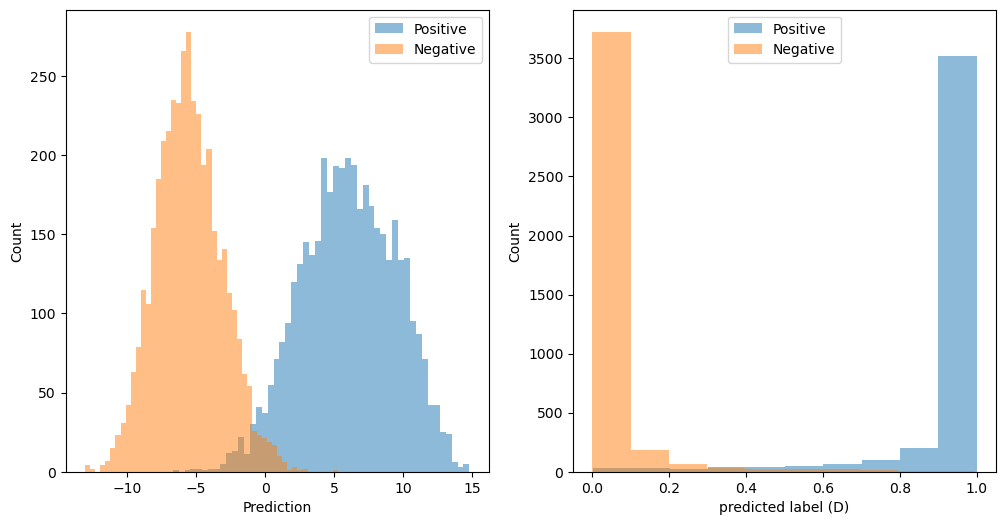

In [5]:
fig = plt.figure(figsize=(12,6))

ax3 = fig.add_subplot(121)
test_pos_val = test_pos_val.asnumpy().reshape(-1)
test_neg_val = test_neg_val.asnumpy().reshape(-1)
ax3.hist(test_pos_val, bins=50, alpha=0.5, label='Positive')
ax3.hist(test_neg_val, bins=50, alpha=0.5, label='Negative')
ax3.legend()
ax3.set_xlabel('Prediction')
ax3.set_ylabel('Count')

ax4 = fig.add_subplot(122)
ax4.hist(test_pos_pred, bins=10, alpha=0.5, label='Positive')
ax4.hist(test_neg_pred, bins=10, alpha=0.5, label='Negative')
ax4.legend()
ax4.set_xlabel('predicted label (D)')
ax4.set_ylabel('Count')

fig.show()